## Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
big = {'figsize':(16,10)}
verbose = False

In [2]:
df = pd.read_csv("../../data/demo/EUR=X.csv", parse_dates=True)
df['Close'] = df['Adj Close']
df.drop(['Adj Close', 'Volume', 'Open'], axis=1, inplace=True)

## cleanup

In [3]:
df.iloc[df['High'].idxmax()] = (df.iloc[df['High'].idxmax()-1].High + df.iloc[df['High'].idxmax()-1].High) / 2
df.iloc[df['High'].idxmax()] = (df.iloc[df['High'].idxmax()-1].High + df.iloc[df['High'].idxmax()-1].High) / 2
df.drop(['Date'], axis=1, inplace=True)
# perhaps we want to keep date. really we want to know the day of week, the day of month and month of year. that's it.
# but we'll handle that later.
df.dropna(inplace=True)

,High,Low,Close
0,0.837240,0.830560,0.835770
1,0.837100,0.825830,0.827200
2,0.828020,0.824400,0.824880
3,0.830290,0.823450,0.827750
4,0.828780,0.820280,0.820550
...,...,...,...
4589,0.847020,0.844500,0.846088
4590,0.846070,0.843668,0.845600
4591,0.849574,0.846200,0.846600
4592,0.847314,0.844096,0.846600


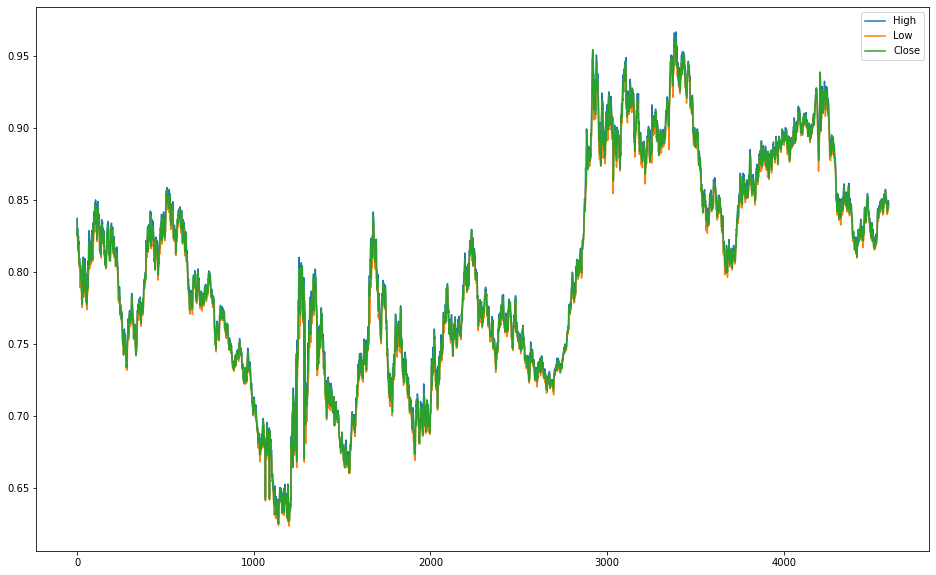

In [4]:
df.reset_index(drop=True, inplace=True)
original = df.copy()
df.plot(**big)
df

## satori exploration

In [5]:
#!pip install fastparquet

In [6]:
#!pip install pyarrow

In [7]:
import satori

In [8]:
d = satori.DataManager()

In [9]:
d.get()

In [10]:
d.data

""


In [11]:
d.append()

In [12]:
d.data

,a
0,1


In [13]:
d.run()

In [14]:
d.data

,a
0,1
0,1


In [15]:
m = satori.ModelManager()

In [16]:
m.data

,a
0,1
0,1


In [17]:
m.targetKey

''

## model creation

In [18]:
d = satori.DataManager(data=df)
d.data

,High,Low,Close
0,0.837240,0.830560,0.835770
1,0.837100,0.825830,0.827200
2,0.828020,0.824400,0.824880
3,0.830290,0.823450,0.827750
4,0.828780,0.820280,0.820550
...,...,...,...
4589,0.847020,0.844500,0.846088
4590,0.846070,0.843668,0.845600
4591,0.849574,0.846200,0.846600
4592,0.847314,0.844096,0.846600


In [19]:
d.save()

In [20]:
m = satori.ModelManager()
m.data

,High,Low,Close
0,0.837240,0.830560,0.835770
1,0.837100,0.825830,0.827200
2,0.828020,0.824400,0.824880
3,0.830290,0.823450,0.827750
4,0.828780,0.820280,0.820550
...,...,...,...
4589,0.847020,0.844500,0.846088
4590,0.846070,0.843668,0.845600
4591,0.849574,0.846200,0.846600
4592,0.847314,0.844096,0.846600


In [21]:
def create_daily_feature(df, yesterday=1, column='High'):
    return df.loc[:, column].shift(yesterday-1) / df.loc[:, column].shift(yesterday)

high1 = lambda x: create_daily_feature(x, 1)
low1 = lambda x: create_daily_feature(x, 1, 'Low')
close1 = lambda x: create_daily_feature(x, 1, 'Close')

In [22]:
params = [
    satori.HyperParameter(
        name='n_estimators',
        value=300,
        kind=int,
        limit=100,
        minimum=200,
        maximum=5000)
]

In [23]:
m = satori.ModelManager(
    #dataPath:str='data.parquet', 
    hyperParameters=params,
    features={'high1':high1, 'low1': low1, 'close1': close1},
    chosenFeatures=['close1'],
    targetKey='High')
    #target:'function'=None, 
    #reverseTarget:'function'=None,
m.data

,High,Low,Close
0,0.837240,0.830560,0.835770
1,0.837100,0.825830,0.827200
2,0.828020,0.824400,0.824880
3,0.830290,0.823450,0.827750
4,0.828780,0.820280,0.820550
...,...,...,...
4589,0.847020,0.844500,0.846088
4590,0.846070,0.843668,0.845600
4591,0.849574,0.846200,0.846600
4592,0.847314,0.844096,0.846600


In [24]:
m.featureSet

,Close
0,NaN
1,0.989746
2,0.997195
3,1.003479
4,0.991302
...,...
4589,1.002070
4590,0.999423
4591,1.001183
4592,1.000000


In [25]:
m.chosenFeatures

['close1']

In [26]:
m.produceTestFeatures()
m.testFeatures

['close1']

In [27]:
m.produceTestFeatureSet()
m.testFeatureSet

,Close
0,NaN
1,0.989746
2,0.997195
3,1.003479
4,0.991302
...,...
4589,1.002070
4590,0.999423
4591,1.001183
4592,1.000000


In [28]:
m.featureSet

,Close
0,NaN
1,0.989746
2,0.997195
3,1.003479
4,0.991302
...,...
4589,1.002070
4590,0.999423
4591,1.001183
4592,1.000000


In [29]:
m.produceTarget()
m.target

,Target_High
0,0.999833
1,0.989153
2,1.002741
3,0.998181
4,0.992748
...,...
4589,0.998878
4590,1.004142
4591,0.997340
4592,0.999865


In [30]:
m.producePredictable()
m.current

,Close
4593,1.0


In [31]:
m.produceTrainingSet()
m.trainX

,Close
0,NaN
1,0.989746
2,0.997195
3,1.003479
4,0.991302
...,...
3669,0.997709
3670,0.999268
3671,0.992698
3672,1.005067


In [32]:
m.testX

,Close
3674,0.998912
3675,1.009224
3676,1.000601
3677,1.000650
3678,0.995859
...,...
4588,1.002660
4589,1.002070
4590,0.999423
4591,1.001183


In [33]:
m.trainY

,Target_High
0,0.999833
1,0.989153
2,1.002741
3,0.998181
4,0.992748
...,...
3669,1.001141
3670,0.997956
3671,1.000832
3672,1.006932


In [34]:
m.testY

,Target_High
3674,1.005071
3675,0.999194
3676,0.999193
3677,0.995950
3678,1.000614
...,...
4588,0.999752
4589,0.998878
4590,1.004142
4591,0.997340


In [35]:
m.hyperParameters[0].test

300

In [36]:
m.produceTestHyperParameters()
m.hyperParameters[0].test

300

In [37]:
m.hyperParameters[0].value

300

In [38]:
m.produceFit()
m.xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [39]:
m.produceTestTrainingSet()
m.produceTestFit()
m.xgbTest

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [40]:
m.evaluateCandidate(returnBoth=True)

(-0.594749043945102, -0.594749043945102)

In [41]:
m.chosenFeatures, m.testFeatures

(['close1'], ['close1'])

In [42]:
m.producePrediction()

0.84753376

In [43]:
m.hyperParameters[0].value

300

# Learner

In [44]:
from threading import *
import time

def dataWaiter():
    def validate(x) -> bool:
        if x != '' and x > 0 and x < 2:
            return True
        return False

    def signal():
        print(h,l,c)
        event.clear()
        event.set()
        
    event.set() # let them run from the beginning if data already present
    while True:
        # doesn't work because of '\r' but thats ok, we'll get data from online anyway
        h = input('what is high?')
        l = input('what is low?')
        c = input('what is close?')
        if validate(h) and validate(l) and validate(c):
            signal()
        
def highLearner():
    def buildStable():
        m.produceTarget()
        m.producePredictable()
        m.produceFeatureSet()
        m.produceTrainingSet()
        m.produceFit()
    
    def coolDown():
        time.sleep(sleep)
        
    def create_daily_feature(df, yesterday=1, column='High'):
        return df.loc[:, column].shift(yesterday-1) / df.loc[:, column].shift(yesterday)

    high1 = lambda x: create_daily_feature(x, 1)
    low1 = lambda x: create_daily_feature(x, 1, 'Low')
    close1 = lambda x: create_daily_feature(x, 1, 'Close')
    params = [
        satori.HyperParameter(
            name='n_estimators',
            value=300,
            kind=int,
            limit=100,
            minimum=200,
            maximum=5000)]
    sleep = 1 # made for laptops - if too hot set a time to rest each itteration 
    
    d = satori.DataManager(data=df)
    d.save()
    m = satori.ModelManager(
        hyperParameters=params,
        features={'high1':high1, 'low1': low1, 'close1': close1},
        chosenFeatures=['close1'],
        targetKey='High')
    
    while True:
        print('waiting for data...', end='\r', flush=True)
        event.wait()
        
        print('building models...', end='\r', flush=True)
        buildStable()
        print('Stable Prediction: ', m.producePrediction(), end='\r', flush=True)
        while event.isSet():
            m.produceTestFeatures()
            m.produceTestFeatureSet()
            m.produceTestTrainingSet()
            m.produceTestHyperParameters()
            m.produceTestFit()
            stable, test = m.evaluateCandidate(returnBoth=True)
            if stable < test:
                buildStable()
            print(
                'Stable Prediction:', m.producePrediction(), 
                'Stable Score:', stable,
                'Test Score', test,
                end='\r', flush=True)
            coolDown()
            
            
        print('fetching new data...', end='\r', flush=True)
        
event=Event()
t1=Thread(target=dataWaiter)
t2=Thread(target=highLearner)
t1.start()
t2.start()